# Test of the algorithm on different dimensions

In [1]:
# Imports
import numpy as np
import torch
from gradNS import Param, NestedSampler, EllipsoidalNS, SliceNS, DynamicNestedSampler, HamiltonianNS
from getdist import plots, MCSamples
import time

# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = 10
mpl.rcParams['axes.linewidth'] = 1.5
#mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

/Users/pablo/miniconda3/envs/gns/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def sample_gaussian(ndims = 2, sampler = 'nested', sigma=0.05):
    #assert sampler in ['nested', 'multinest', 'polychord', 'gannest']
    mvn = torch.distributions.MultivariateNormal(loc=torch.zeros(ndims),
                                             scale_tril=torch.diag(
                                                 torch.ones(ndims)))

    
    params = []
    for i in range(ndims):
        p = Param(
                name=f'p{i}',
                prior_type='Uniform',
                prior=(-5, 5),
                label=f'p_{i}')
        params.append(p)
        
    if sampler == 'base':
        ns = NestedSampler(
            nlive=25 * ndims,
            loglike=mvn.log_prob,
            params=params,
            clustering=False,
            verbose=False)
    elif sampler == 'ellipsoidal':
        ns = EllipsoidalNS(
            nlive=25 * ndims,
            loglike=mvn.log_prob,
            params=params,
            eff=0.1,
            clustering=False,
            verbose=False)
    elif sampler == 'slice':
        ns = SliceNS(
            nlive=25 * ndims,
            loglike=mvn.log_prob,
            params=params,
            clustering=False,
            verbose=False)
    elif sampler == 'dynamic':
        ns = DynamicNestedSampler(
                    nlive=25 * ndims,
                    loglike=mvn.log_prob,
                    params=params,
                    clustering=True,
                    verbose=False)
    elif sampler == 'hamiltonian':
        ns = HamiltonianNS(
            nlive=200, 
            loglike=mvn.log_prob,
            params=params,
            tol=1e-2,
            min_reflections=3, 
            max_reflections=5,
            sigma_vel=sigma,
            #dt_ini=0.05,
            clustering=False,
            verbose=False)
        
    ns.run()
    an_samples = ns.convert_to_anesthetic()
    lZ = an_samples.logZ(nsamples=100)
    return ns.get_mean_logZ(), ns.get_var_logZ()**0.5, ns.get_like_evals()

In [3]:
dims = [4, 8, 16, 32, 64, 128]
logZ_true = np.zeros_like(dims, dtype=np.float32)

logZ = np.zeros_like(dims, dtype=np.float32)
err_logZ = np.zeros_like(dims, dtype=np.float32)
like_evals = np.zeros_like(dims, dtype=np.int32)

times = np.zeros_like(dims, dtype=np.float32)

num_repeats = 10

for i, d in enumerate(dims): 
    logZ_true[i] = np.log(1 / 10.**d)
    print(f"D = {d}, logZ = {logZ_true[i]:.4f}")
    
    logZ_local = np.zeros(num_repeats, dtype=np.float32)
    err_logZ_local = np.zeros(num_repeats, dtype=np.float32)
    like_evals_local = np.zeros(num_repeats, dtype=np.int32)
    times_local = np.zeros(num_repeats, dtype=np.float32)
    for j in range(num_repeats):
        start_time = time.time()
        logZ_local[j], err_logZ_local[j], like_evals_local[j] = sample_gaussian(ndims = d, sampler = 'hamiltonian')
        times_local[j] = time.time() - start_time
        
    logZ[i] = np.mean(logZ_local)
    err_propagated = np.sqrt(np.sum(err_logZ_local**2))/len(err_logZ_local)
    err_logZ[i] = np.sqrt(err_propagated**2 + np.std(logZ_local)**2)
    like_evals[i] = np.mean(like_evals_local)
    times[i] = np.mean(times_local)
    
    print(f"logZ = {logZ[i]:.4f} +/- {err_logZ[i]:.4f}, like_evals = {like_evals[i]}, time = {times[i]:.4f}")

D = 4, logZ = -9.2103
logZ = -9.1852 +/- 0.1540, like_evals = 50254, time = 3.5951
D = 8, logZ = -18.4207
logZ = -18.5326 +/- 0.2369, like_evals = 68175, time = 4.8137
D = 16, logZ = -36.8414
logZ = -37.4207 +/- 0.6445, like_evals = 99767, time = 7.5970
D = 32, logZ = -73.6827
logZ = -75.2602 +/- 0.8754, like_evals = 145964, time = 13.1720
D = 64, logZ = -147.3654
logZ = -150.7174 +/- 1.4082, like_evals = 240022, time = 28.4449
D = 128, logZ = -294.7309
logZ = -307.4919 +/- 3.0639, like_evals = 433233, time = 63.1858


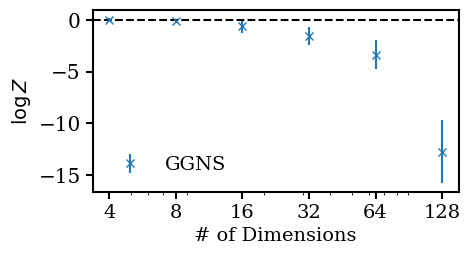

In [4]:
x_size=12
y_size=6
fontsize = 14
fig, ax = plt.subplots(figsize=(x_size/2.54,y_size/2.54))
ax.errorbar(dims, logZ - logZ_true, yerr=err_logZ, fmt='x', label='GGNS')
ax.axhline(0, ls='--', color='k')
ax.set_xscale('log')
ax.set_xlabel("# of Dimensions", fontsize=fontsize)
ax.set_ylabel(r"$ \log Z$", fontsize=fontsize)
ax.set_xticks(dims)
ax.set_xticklabels(np.array(dims, dtype='str'), fontsize=fontsize)
plt.legend(fontsize=fontsize)

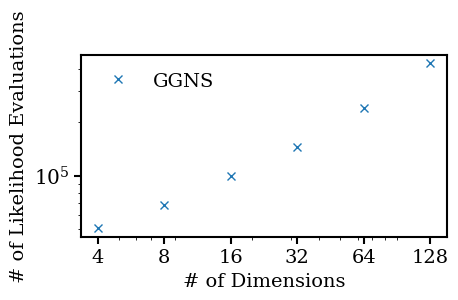

In [5]:
x_size=12
y_size=6
fontsize = 14
fig, ax = plt.subplots(figsize=(x_size/2.54,y_size/2.54))
ax.errorbar(dims, like_evals, fmt='x', label='GGNS')
ax.axhline(0, ls='--', color='k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel("# of Dimensions", fontsize=fontsize)
ax.set_ylabel(r"# of Likelihood Evaluations", fontsize=fontsize)
ax.set_xticks(dims)
ax.set_xticklabels(np.array(dims, dtype='str'), fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [6]:
lz = np.stack([dims, logZ, err_logZ, like_evals, times], axis=1)
np.save('/Users/pablo/Code/GradNS_dev/nb/data/hamiltonian_logZ_nsteps20_v2', lz)

In [7]:
data = np.load('/Users/pablo/Code/GradNS_dev/nb/data/hamiltonian_logZ_v4.npy')
dims2, logZ2, err_logZ2, like_evals2, times2 = data[:,0], data[:,1], data[:,2], data[:,3], data[:,4]

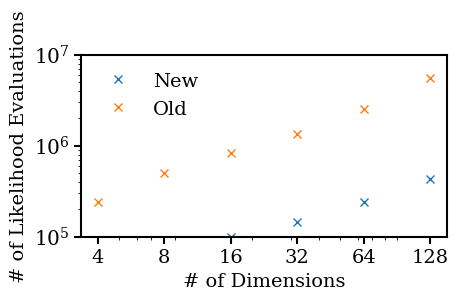

In [8]:
x_size=12
y_size=6
fontsize = 14
fig, ax = plt.subplots(figsize=(x_size/2.54,y_size/2.54))
ax.errorbar(dims, like_evals, fmt='x', label='New')
ax.errorbar(dims2, like_evals2, fmt='x', label='Old')
ax.axhline(0, ls='--', color='k')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e5, 1e7])
ax.set_xlabel("# of Dimensions", fontsize=fontsize)
ax.set_ylabel(r"# of Likelihood Evaluations", fontsize=fontsize)
ax.set_xticks(dims)
ax.set_xticklabels(np.array(dims, dtype='str'), fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [9]:
like_evals

array([ 50254,  68175,  99767, 145964, 240022, 433233], dtype=int32)

ValueError: operands could not be broadcast together with shapes (5,) (6,) 

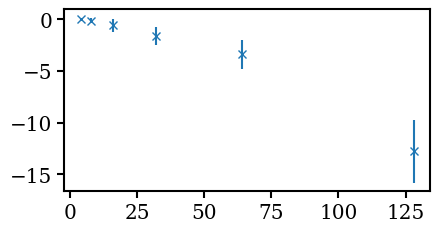

In [10]:
x_size=12
y_size=6
fontsize = 14
fig, ax = plt.subplots(figsize=(x_size/2.54,y_size/2.54))
ax.errorbar(dims, logZ - logZ_true, yerr=err_logZ, fmt='x', label='New')
ax.errorbar(dims2[:-1]*1.1, logZ2[:-1] - logZ_true, yerr=err_logZ2[:-1], fmt='x', label='Old')
ax.axhline(0, ls='--', color='k')
ax.set_xscale('log')
ax.set_xlabel("# of Dimensions", fontsize=fontsize)
ax.set_ylabel(r"$ \log Z$", fontsize=fontsize)
ax.set_xticks(dims)
ax.set_xticklabels(np.array(dims, dtype='str'), fontsize=fontsize)
plt.legend(fontsize=fontsize)

In [ ]:
!ls /Users/pablo/Code/GradNS_dev/nb/data/hamiltonian_logZ_*